In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from skimage.feature import hog

Using TensorFlow backend.


In [2]:
def get_imgs(paths, directory):  
    
    imgs_bgr = []
    imgs_rgb = []
    for i in range(len(paths)): 
        if 'image' in str(paths[i]): 
            img = cv2.imread(directory+ '/'+ str(paths[i]))
            imgs_bgr.append(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imgs_rgb.append(img)
        
    return imgs_bgr, imgs_rgb

In [3]:
def get_hog_features(imgs):  
    hog_features = []
    for i in range(len(imgs)):
        gray_img = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)
        fd = hog(gray_img, orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2')
        hog_features.append(fd)

    return np.array(hog_features)

In [4]:
train_directory = "./Penguins_vs_Turtles/archive/train/train"
valid_directory = "./Penguins_vs_Turtles/archive/valid/valid"
train_annotations_path = "./Penguins_vs_Turtles/archive/train_annotations"
valid_annotations_path = "./Penguins_vs_Turtles/archive/valid_annotations"

train_paths = os.listdir(train_directory)
valid_paths = os.listdir(valid_directory)
train_annotations = pd.read_json(train_annotations_path)
valid_annotations = pd.read_json(valid_annotations_path)

In [5]:
train_imgs_bgr, train_imgs_rgb = get_imgs(train_paths, train_directory)
valid_imgs_bgr, valid_imgs_rgb = get_imgs(valid_paths, valid_directory)
train_labels =  np.array(train_annotations["category_id"]).astype(int).reshape(len(train_annotations["category_id"]), 1).ravel()
valid_labels =  np.array(valid_annotations["category_id"]).astype(int).reshape(len(valid_annotations["category_id"]), 1).ravel()
train_hog_features = get_hog_features(train_imgs_bgr)
valid_hog_features = get_hog_features(valid_imgs_bgr)

In [6]:
clf = SVC()
clf.fit(train_hog_features, train_labels.ravel())
pred_1 = clf.predict(valid_hog_features)

In [7]:
"Accuracy: "+str(accuracy_score(valid_labels, pred_1))

'Accuracy: 0.7638888888888888'

In [8]:
print(classification_report(valid_labels, pred_1))

              precision    recall  f1-score   support

           1       0.83      0.67      0.74        36
           2       0.72      0.86      0.78        36

    accuracy                           0.76        72
   macro avg       0.77      0.76      0.76        72
weighted avg       0.77      0.76      0.76        72



Use sliding window to find bounding boxes 

In [9]:
def get_bounding_boxes(img, w_range, h_range, window_step_size, step_size, clf, type):
    
    bounding_boxes = []
    detection_score_list = []
    detection_score = -np.inf
    hog_features = []
    
    # Iterate over the range of window sizes
    for window_width in range(w_range[0], w_range[1], window_step_size):
        for window_height in range(h_range[0], h_range[1], window_step_size):
            for y in range(0, img.shape[0] - window_height, step_size):
                for x in range(0, img.shape[1] - window_width, step_size):
                    window = img[y:y+window_height, x:x+window_width]
                    window = cv2.resize(window, (640,640))
                    hog_feature = hog(window, orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2')
                    prediction = clf.predict([hog_feature])
                    if prediction == type:
                        detection_score = clf.decision_function([hog_feature])[0]
                        bounding_boxes.append((x, y, x+window_width, y+window_height))
                        hog_features.append(hog_feature)
                        detection_score_list.append(detection_score)
                
    return bounding_boxes, hog_features, detection_score_list

In [10]:
def draw_img(image, bounding_boxes, detection_score_list, index, type):
    for i in index: 
        x = int(bounding_boxes[i][0])
        y = int(bounding_boxes[i][1])
        xx = int(bounding_boxes[i][2])
        yy = int(bounding_boxes[i][3])
        cv2.rectangle(image, (x, y), (xx, yy), (0, 255, 0), 2)
        if type == 1:
            # Write text beside the rectangle
            text = f"P:{round(detection_score_list[i], 5)+1}"
            cv2.putText(image, text, (xx + 10, yy // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
        else: 
            # Write text beside the rectangle
            text = f"T:{1-round(detection_score_list[i], 5)}"
            cv2.putText(image, text, (xx + 10, yy // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
    return image

In [11]:
def calculate_distance_and_iou(predicted_bbox, true_bbox, true_area):
    # Calculate centers of predicted and true bounding boxes
    pred_center = [(predicted_bbox[0] + predicted_bbox[2]) / 2, (predicted_bbox[1] + predicted_bbox[3]) / 2]
    true_center = [(true_bbox[0] + true_bbox[2]) / 2, (true_bbox[1] + true_bbox[3]) / 2]
    
    # Calculate distance between predicted and true centers
    distance = np.linalg.norm(np.array(pred_center) - np.array(true_center))
    
    # Calculate IoU score
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = predicted_bbox
    x_min_true, y_min_true, x_max_true, y_max_true = true_bbox

    intersection_area = max(0, min(x_max_pred, x_max_true) - max(x_min_pred, x_min_true)) * max(0, min(y_max_pred, y_max_true) - max(y_min_pred, y_min_true))
    
    pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    
    union_area = pred_area + true_area - intersection_area
    
    iou_score = intersection_area / union_area
    
    return distance, iou_score

In [12]:
def get_coor(bbox): 
    x = bbox[0]
    y = bbox[1]
    xx = bbox[0]+ bbox[2]
    yy = bbox[1]+ bbox[3]
    return (x, y, xx, yy)

In [13]:
bounding_boxes_1, hog_features_1, detection_score_list_1 = get_bounding_boxes(cv2.cvtColor(valid_imgs_bgr[0],cv2.COLOR_BGR2GRAY), (0, 640), (0, 640), 16, 16,clf, 1)

In [14]:
sorted_indices = sorted(range(len(detection_score_list_1)), key=lambda i: detection_score_list_1[i], reverse=True)
top_10_indices_1 = sorted_indices[:10]

In [15]:
top_10_indices_1

[125, 28, 42, 84, 51, 92, 113, 21, 20, 85]

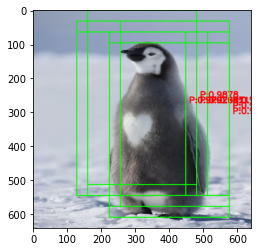

In [16]:
img_1_1 = valid_imgs_bgr[0].copy()
image = draw_img(img_1_1, bounding_boxes_1, detection_score_list_1, top_10_indices_1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

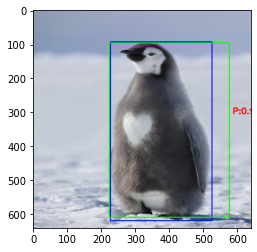

In [17]:
true_bbox_1 = get_coor(valid_annotations["bbox"][0])
img_1_2 = valid_imgs_bgr[0].copy()
cv2.rectangle(img_1_2, (true_bbox_1[0], true_bbox_1[1]), (true_bbox_1[2], true_bbox_1[3]), (255, 0, 0), 2)
image = draw_img(img_1_2, bounding_boxes_1, detection_score_list_1, [top_10_indices_1[0]], 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [18]:
calculate_distance_and_iou(bounding_boxes_1[top_10_indices_1[0]],true_bbox_1, valid_annotations["area"][0])

(24.253865671269807, 0.8287759780117111)

In [19]:
bounding_boxes_2, hog_features_2, detection_score_list_2 = get_bounding_boxes(cv2.cvtColor(valid_imgs_bgr[6],cv2.COLOR_BGR2GRAY), (0, 640), (0, 640), 32, 32,clf, 2)
sorted_indices = sorted(range(len(detection_score_list_2)), key=lambda i: detection_score_list_2[i])
top_10_indices_2 = sorted_indices[:10]

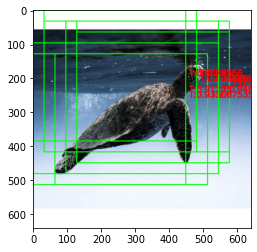

In [20]:
img_2_1 = valid_imgs_bgr[6].copy()
image = draw_img(img_2_1, bounding_boxes_2, detection_score_list_2, top_10_indices_2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

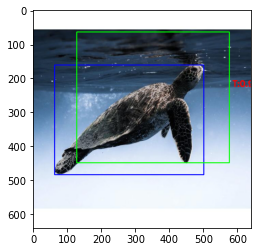

In [21]:
img_2_2 = valid_imgs_bgr[6].copy()
true_bbox_2 = get_coor(valid_annotations["bbox"][6])
cv2.rectangle(img_2_2, (true_bbox_2[0], true_bbox_2[1]), (true_bbox_2[2], true_bbox_2[3]), (255, 0, 0), 2)
image = draw_img(img_2_2, bounding_boxes_2, detection_score_list_2, [top_10_indices_2[0]], 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [22]:
calculate_distance_and_iou(bounding_boxes_2[top_10_indices_2[0]],true_bbox_2, valid_annotations["area"][6])

(96.20810776644555, 0.5196221671027148)

extra feature 1: more features 

In [23]:
# get MobileNet features from the training set
def get_cnn_features(imgs):
    
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    cnn_features = []
    for image in imgs:
        resized_image = cv2.resize(image, (224, 224))
        preprocessed_image = np.expand_dims(resized_image, axis=0)
        preprocessed_image = preprocess_input(preprocessed_image)
        features = base_model.predict(preprocessed_image)
        cnn_features.append(features.flatten())
    return np.array(cnn_features)

In [24]:
def get_scaled_features(cnn_features, hog_features): 
    combined_features = np.concatenate((hog_features, cnn_features), axis=1)
    scaler = StandardScaler()
    return scaler.fit_transform(combined_features)

In [25]:
# get the training and testing sets
X_train, X_test, y_train, y_test = train_imgs_bgr, valid_imgs_bgr, train_labels, valid_labels

# Extract MobileNet features from the training set
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
train_cnn_features = get_cnn_features(X_train)
valid_cnn_features = get_cnn_features(X_test)
# Combine the HOG and MobileNet features
combined_features = np.concatenate((train_hog_features, train_cnn_features), axis=1)

# Scale the features
scaled_features = get_scaled_features(train_cnn_features, train_hog_features)

# Train the ensemble classifier
svm_clf = SVC(probability=True)
ensemble_clf = VotingClassifier(estimators=[('svm', svm_clf)], voting='soft')
ensemble_clf.fit(scaled_features, y_train)

scaled_test_features = get_scaled_features(valid_cnn_features, valid_hog_features)
pred_2 = ensemble_clf.predict(scaled_test_features)

In [26]:
print("Accuracy:", accuracy_score(y_test, pred_2))

Accuracy: 0.8611111111111112


In [27]:
print(classification_report(valid_labels, pred_2))

              precision    recall  f1-score   support

           1       0.84      0.89      0.86        36
           2       0.88      0.83      0.86        36

    accuracy                           0.86        72
   macro avg       0.86      0.86      0.86        72
weighted avg       0.86      0.86      0.86        72



extra feature 2: use non_max_suppression method to choose one bounding box 

In [28]:
def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    if len(boxes[pick]) != 1: 
        pick = np.sum(boxes[pick], axis=0) / 2
    else: 
        pick = boxes[pick][0]
    return pick

In [29]:
top_10_2 = [bounding_boxes_2[i] for i in top_10_indices_2] 

In [30]:
result = non_max_suppression(top_10_2, 0.3)

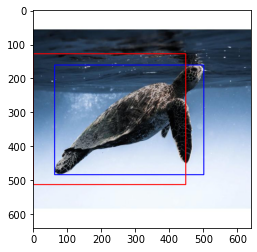

In [31]:
img_2_3 = valid_imgs_bgr[6].copy()
cv2.rectangle(img_2_3, (true_bbox_2[0], true_bbox_2[1]), (true_bbox_2[2], true_bbox_2[3]), (255, 0, 0), 2)
cv2.rectangle(img_2_3, (result[0], result[1]), (result[2], result[3]), (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(img_2_3, cv2.COLOR_BGR2RGB))